In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-for-stock-and-tweet/archive (5)/TSLA-2.csv
/kaggle/input/dataset-for-stock-and-tweet/archive (5)/HistoricalData_1726367135218.csv
/kaggle/input/dataset-for-stock-and-tweet/archive (5)/tsla_2025.csv
/kaggle/input/dataset-for-stock-and-tweet/archive (4)/elon_musk_tweets.csv
/kaggle/input/dataset-for-stock-and-tweet/archive (4)/wandb/run-20230613_064834-3fmloyay/run-3fmloyay.wandb
/kaggle/input/dataset-for-stock-and-tweet/archive (4)/wandb/run-20230613_064834-3fmloyay/logs/debug.log
/kaggle/input/dataset-for-stock-and-tweet/archive (4)/wandb/run-20230613_064834-3fmloyay/logs/debug-internal.log
/kaggle/input/dataset-for-stock-and-tweet/archive (4)/wandb/run-20230613_064834-3fmloyay/files/wandb-summary.json
/kaggle/input/dataset-for-stock-and-tweet/archive (4)/wandb/run-20230613_064834-3fmloyay/files/conda-environment.yaml
/kaggle/input/dataset-for-stock-and-tweet/archive (4)/wandb/run-20230613_064834-3fmloyay/files/config.yaml
/kaggle/input/dataset-for-stock-and-tweet

## Step 1: Suppress Warnings
_Using warnings filter to ignore runtime warnings for cleaner output during analysis._


In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


#  Analysis:

> Useful for avoiding clutter during execution (e.g., in numerical computations).

> Caution: Hiding warnings can mask real issues—use selectively!




# Step 2: Perform Sentiment Analysis on Tweets


## 2.1: Load and Inspect Elon Musk Tweets

> Loads Elon Musk’s tweets from a CSV file into a Pandas DataFrame.

> Displays the first 5 rows (tweets_df.head()) and checks for missing values in date and text columns.





In [3]:
# Import necessary libraries
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load the tweet data (replace with your actual file path or dataset)
tweets_df = pd.read_csv('/kaggle/input/dataset-for-stock-and-tweet/archive (4)/elon_musk_tweets.csv')  # Adjust path as necessary

# Display the first few rows to check if the data is loaded properly
print(tweets_df.head())

# Check for any missing values in critical columns (date, text)
print(tweets_df[['date', 'text']].isnull().sum())


                    id  user_name user_location           user_description  \
0  1544379368478212100  Elon Musk           NaN  Mars & Cars, Chips & Dips   
1  1544377493263720450  Elon Musk           NaN  Mars & Cars, Chips & Dips   
2  1544377130590552064  Elon Musk           NaN  Mars & Cars, Chips & Dips   
3  1544375575724400645  Elon Musk           NaN  Mars & Cars, Chips & Dips   
4  1544375148605853699  Elon Musk           NaN  Mars & Cars, Chips & Dips   

                user_created  user_followers  user_friends  user_favourites  \
0  2009-06-02 20:12:29+00:00       101240855           115            13503   
1  2009-06-02 20:12:29+00:00       101240806           115            13503   
2  2009-06-02 20:12:29+00:00       101240806           115            13503   
3  2009-06-02 20:12:29+00:00       101240806           115            13503   
4  2009-06-02 20:12:29+00:00       101240806           115            13503   

   user_verified                       date  \
0        

# Analysis:
> Data loaded successfully with columns: id, user_name, text, date, retweets, etc.

> No missing values in date or text (critical for sentiment analysis).

> Example tweet: "Sock tech is so advanced that you can get pret..." (humorous tone).




## 2.2: Preprocess Tweet Data
> Converts date to datetime format with errors='coerce' (silently handles invalid dates → NaT).

> Checks for failed conversions (empty output means all dates were valid).

> Drops rows with missing date or text (though none were found here).

> Displays cleaned data (first 5 rows, confirming structure is intact).




In [4]:
# Convert the 'date' column to datetime format (handle errors if any)
tweets_df['date'] = pd.to_datetime(tweets_df['date'], errors='coerce')

# Display any rows where the date conversion failed (if any)
print(tweets_df[tweets_df['date'].isnull()])

# Remove rows with missing 'date' or 'text' columns
tweets_df = tweets_df.dropna(subset=['date', 'text'])

# Display the cleaned data
print(tweets_df.head())


Empty DataFrame
Columns: [id, user_name, user_location, user_description, user_created, user_followers, user_friends, user_favourites, user_verified, date, text, hashtags, source, retweets, favorites, is_retweet]
Index: []
                    id  user_name user_location           user_description  \
0  1544379368478212100  Elon Musk           NaN  Mars & Cars, Chips & Dips   
1  1544377493263720450  Elon Musk           NaN  Mars & Cars, Chips & Dips   
2  1544377130590552064  Elon Musk           NaN  Mars & Cars, Chips & Dips   
3  1544375575724400645  Elon Musk           NaN  Mars & Cars, Chips & Dips   
4  1544375148605853699  Elon Musk           NaN  Mars & Cars, Chips & Dips   

                user_created  user_followers  user_friends  user_favourites  \
0  2009-06-02 20:12:29+00:00       101240855           115            13503   
1  2009-06-02 20:12:29+00:00       101240806           115            13503   
2  2009-06-02 20:12:29+00:00       101240806           115            1

# Analysis:
> No date parsing errors (Empty DataFrame confirms all timestamps are valid).

> Data structure preserved: Columns like text, retweets, and date remain intact.

> Sample tweets show informal language (e.g., "Sock tech is so advanced..."), which VADER handles well


# 2.3: Apply VADER Sentiment Analysis
> Initializes VADER (SentimentIntensityAnalyzer()) to analyze tweet sentiment.

> Calculates compound scores (ranging from -1 to +1) for each tweet:

> 0.05 → Positive

> -0.05 → Negative

> Between -0.05 and 0.05 → Neutral

> Applies sentiment analysis to the raw text column (without preprocessing, which is fine for VADER).




In [5]:
# VADER Sentiment Analysis
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment analysis and return compound score
def get_vader_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']  # Compound score is a single score

# Apply VADER sentiment analysis on the 'text' column
tweets_df['sentiment'] = tweets_df['text'].apply(get_vader_sentiment)

# Display the first few rows with sentiment values
print(tweets_df[['text', 'sentiment']].head())

# Optionally, check the sentiment for a sample tweet manually
example_tweet = tweets_df['text'].iloc[0]  # Just taking the first tweet as an example
print(f"Example Tweet: {example_tweet}")
print(f"Sentiment Score: {sia.polarity_scores(example_tweet)}")


                                                text  sentiment
0  @BillyM2k I find the gold toe sock – inevitabl...    -0.6378
1                 Sock Con, the conference for socks     0.0000
2  Always something new for the magazine cover an...     0.0000
3                   @ExplainThisBob This guy gets it     0.0000
4  Sock tech is so advanced that you can get pret...     0.7276
Example Tweet: @BillyM2k I find the gold toe sock – inevitably off kilter &amp; washed out – a little troubling esthetically &amp; arguably a bit corpo
Sentiment Score: {'neg': 0.234, 'neu': 0.766, 'pos': 0.0, 'compound': -0.6378}


# Analysis:
Each tweet now has a sentiment score, which indicates whether the sentiment is positive, negative, or neutral. This data will help correlate sentiment with stock price movements later.


Here's a quick breakdown of the sentiment score components:

Negative (neg): 0.234

Neutral (neu): 0.766

Positive (pos): 0.0

Compound: -0.6378 (Overall sentiment)



## Step 3: Load and Preprocess Tesla Stock Data
 


## 3.1: Import Required Libraries
_Importing essential libraries like pandas for data handling._


In [6]:
import pandas as pd


## 3.2: Load Tesla Stock Price Dataset
> Loads Tesla stock data (2010–2025) with columns: Date, Open, High, Low, Close, Volume.

> Shows early trading days (e.g., $1.13 opening price in 2010 vs. current highs).



In [7]:
# Load the Tesla stock data from the given CSV file
stock_data_path = '/kaggle/input/dataset-for-stock-and-tweet/archive (5)/tsla_2025.csv'
tesla_stock_data = pd.read_csv(stock_data_path)

# Display the first few rows of the dataset to check its structure
tesla_stock_data.head()


,Date,Open,High,Low,Close,Volume
0,2010-06-28,1.13333,1.13333,1.13333,1.13333,0
1,2010-06-29,1.26667,1.66667,1.16933,1.59267,281749140
2,2010-06-30,1.71933,2.02800,1.55333,1.58867,257915910
3,2010-07-01,1.66667,1.72800,1.35133,1.46400,123447945
4,2010-07-02,1.53333,1.54000,1.24733,1.28000,77127105


# Step 4: Load and Preprocess Sentiment (Tweet) Data


## 4.1: Load Elon Musk Tweet Dataset



In [8]:
#  Step 4.1: Load the sentiment data (tweets)
# Replace this path with the actual path to your sentiment CSV file
sentiment_data_path = '/kaggle/input/dataset-for-stock-and-tweet/archive (4)/elon_musk_tweets.csv'

# Load the dataset
sentiment_df = pd.read_csv(sentiment_data_path)

# Convert the 'date' column to datetime format and standardize it to 'YYYY-MM-DD'
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.strftime('%Y-%m-%d')

# Preview the dataset
sentiment_df.head()


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1544379368478212100,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240855,115,13503,True,2022-07-05,@BillyM2k I find the gold toe sock – inevitabl...,NaN,Twitter for iPhone,335,6542,False
1,1544377493263720450,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05,"Sock Con, the conference for socks",NaN,Twitter for iPhone,1451,30753,False
2,1544377130590552064,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05,Always something new for the magazine cover an...,NaN,Twitter for iPhone,1284,28610,False
3,1544375575724400645,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05,@ExplainThisBob This guy gets it,NaN,Twitter for iPhone,131,3640,False
4,1544375148605853699,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05,Sock tech is so advanced that you can get pret...,NaN,Twitter for iPhone,1191,23790,False


## 4.2: Apply Sentiment Analysis using VADER
_Applying VADER sentiment analysis to each tweet and labeling it as positive, negative, or neutral based on the compound score._


In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis on the 'text' column of the tweets
sentiment_df['compound'] = sentiment_df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# You can categorize the sentiment based on the compound score:
sentiment_df['sentiment'] = sentiment_df['compound'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Check the updated dataframe with sentiment labels
sentiment_df[['date', 'text', 'compound', 'sentiment']].head()


,date,text,compound,sentiment
0,2022-07-05,@BillyM2k I find the gold toe sock – inevitabl...,-0.6378,negative
1,2022-07-05,"Sock Con, the conference for socks",0.0000,neutral
2,2022-07-05,Always something new for the magazine cover an...,0.0000,neutral
3,2022-07-05,@ExplainThisBob This guy gets it,0.0000,neutral
4,2022-07-05,Sock tech is so advanced that you can get pret...,0.7276,positive


# Step 5: Data Preparation for Merging Sentiment and Stock Data


## 5.1: Load Tesla Stock Price Data
_Loading Tesla stock price data from CSV and verifying if the file exists._


In [10]:
import os
import pandas as pd

# Step 5.1: Provide the correct path to your Tesla stock data CSV file
stock_data_path = '/kaggle/input/dataset-for-stock-and-tweet/archive (5)/tsla_2025.csv'  # Replace with your actual file path

# Step 5.1.1: Load the Tesla stock data if the file exists
if os.path.exists(stock_data_path):
    stock_df = pd.read_csv(stock_data_path)
    print(" Tesla stock data loaded successfully!")
else:
    print(f" Error: The file '{stock_data_path}' does not exist. Please check the file path.")


 Tesla stock data loaded successfully!


## 5.2: Prepare and Clean Stock Data
_Verifying and cleaning the stock dataset: renaming columns and formatting dates._


In [11]:
# Step 5.2: Show column names to verify structure
print(" Columns in the stock data:", stock_df.columns)

# Step 5.2.1: Rename 'Date' column to 'date' for consistency
if 'Date' in stock_df.columns:
    stock_df.rename(columns={'Date': 'date'}, inplace=True)
else:
    print(" Error: 'Date' column not found in stock data.")

# Step 5.2.2: Convert 'date' column to proper datetime format
try:
    stock_df['date'] = pd.to_datetime(stock_df['date']).dt.strftime('%Y-%m-%d')
except Exception as e:
    print(f" Error in date conversion: {e}")


 Columns in the stock data: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


## 5.3: Merge Sentiment and Stock Data
_Combining stock and sentiment datasets based on the common `date` column._


In [12]:
# Step 5.3: Merge with sentiment_df on 'date'
try:
    merged_df = pd.merge(sentiment_df, stock_df, on='date', how='inner')
    print(" Merged sentiment and stock data successfully!")
except Exception as e:
    print(f" Error during merge: {e}")


 Merged sentiment and stock data successfully!


## 5.4: Inspect Merged Dataset
_Quick preview of the combined sentiment and stock dataset._


In [13]:
# Step 3.4: Inspect merged data
print(merged_df.head())


                    id  user_name user_location           user_description  \
0  1544379368478212100  Elon Musk           NaN  Mars & Cars, Chips & Dips   
1  1544377493263720450  Elon Musk           NaN  Mars & Cars, Chips & Dips   
2  1544377130590552064  Elon Musk           NaN  Mars & Cars, Chips & Dips   
3  1544375575724400645  Elon Musk           NaN  Mars & Cars, Chips & Dips   
4  1544375148605853699  Elon Musk           NaN  Mars & Cars, Chips & Dips   

                user_created  user_followers  user_friends  user_favourites  \
0  2009-06-02 20:12:29+00:00       101240855           115            13503   
1  2009-06-02 20:12:29+00:00       101240806           115            13503   
2  2009-06-02 20:12:29+00:00       101240806           115            13503   
3  2009-06-02 20:12:29+00:00       101240806           115            13503   
4  2009-06-02 20:12:29+00:00       101240806           115            13503   

   user_verified        date  ... retweets favorites is_

You successfully:

(a) Aligned tweet data with stock data by date.

(b) Merged sentiment scores into the stock dataframe.

(c) Prepared the combined dataset for modeling.



# Step 6: Data Preparation for LSTM



## 6.1: Select Relevant Features for LSTM
_Selecting the relevant columns such as compound, Open, High, Low, Close, and Volume for model input._


In [14]:
# Step 6.1 - Select relevant columns: compound, Open, High, Low, Close, Volume
df_selected = merged_df[['compound', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Check the columns of the DataFrame
print(df_selected.columns)

# Check the columns of the DataFrame
print(tesla_stock_data.columns)
print(sentiment_df.columns)



Index(['compound', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet', 'compound', 'sentiment'],
      dtype='object')


## 6.2: Preprocess Date and Merge Datasets
_Standardizing the date format and merging the stock data with sentiment data._


In [15]:

# Rename the 'Date' column in the stock data to 'date'
tesla_stock_data.rename(columns={'Date': 'date'}, inplace=True)

# Convert the 'date' column in stock data to the same format as sentiment data
tesla_stock_data['date'] = pd.to_datetime(tesla_stock_data['date']).dt.strftime('%Y-%m-%d')

# Now, merge the datasets
merged_data = pd.merge(tesla_stock_data, sentiment_df, on='date', how='inner')

# Check the first few rows of the merged data
merged_data.head()


,date,Open,High,Low,Close,Volume,id,user_name,user_location,user_description,...,user_favourites,user_verified,text,hashtags,source,retweets,favorites,is_retweet,compound,sentiment
0,2022-07-05,223.0,233.147,216.167,233.067,84779112,1544379368478212100,Elon Musk,NaN,"Mars & Cars, Chips & Dips",...,13503,True,@BillyM2k I find the gold toe sock – inevitabl...,NaN,Twitter for iPhone,335,6542,False,-0.6378,negative
1,2022-07-05,223.0,233.147,216.167,233.067,84779112,1544377493263720450,Elon Musk,NaN,"Mars & Cars, Chips & Dips",...,13503,True,"Sock Con, the conference for socks",NaN,Twitter for iPhone,1451,30753,False,0.0000,neutral
2,2022-07-05,223.0,233.147,216.167,233.067,84779112,1544377130590552064,Elon Musk,NaN,"Mars & Cars, Chips & Dips",...,13503,True,Always something new for the magazine cover an...,NaN,Twitter for iPhone,1284,28610,False,0.0000,neutral
3,2022-07-05,223.0,233.147,216.167,233.067,84779112,1544375575724400645,Elon Musk,NaN,"Mars & Cars, Chips & Dips",...,13503,True,@ExplainThisBob This guy gets it,NaN,Twitter for iPhone,131,3640,False,0.0000,neutral
4,2022-07-05,223.0,233.147,216.167,233.067,84779112,1544375148605853699,Elon Musk,NaN,"Mars & Cars, Chips & Dips",...,13503,True,Sock tech is so advanced that you can get pret...,NaN,Twitter for iPhone,1191,23790,False,0.7276,positive


## 6.3: Normalize the Data for LSTM Input
_Using MinMaxScaler to normalize numerical features such as Open, High, Low, Close, and Volume._


In [16]:
from sklearn.preprocessing import MinMaxScaler

# Assuming merged_data is your final merged DataFrame
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized = scaler.fit_transform(merged_data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Convert normalized data back to DataFrame if necessary
df_normalized = pd.DataFrame(df_normalized, columns=['Open', 'High', 'Low', 'Close', 'Volume'])


## 6.4: Create Sequences for LSTM Model
_Creating sequences of 60 time steps to use as input (X) and the target variable (Close) as output (y)._


In [17]:
# Import NumPy
import numpy as np

# Now, run your code for sequence creation
data = df_normalized.values
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(data)):
    X.append(data[i - sequence_length:i])  # Using the last 60 days as input
    y.append(data[i, df_normalized.columns.get_loc('Close')])  # Target is 'Close'

X, y = np.array(X), np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (3993, 60, 5)
y shape: (3993,)


## Step 7: Build LSTM Model

# 1. Step 7.1 - Import Required Libraries

In [18]:
# Step 7.1 - Import Required Libraries
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Bidirectional, LSTM, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2025-05-04 11:05:40.205673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746356740.511967      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746356740.593620      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Step 7.2 - Prepare Data for LSTM Input



In [19]:
# Step 7.2 - Prepare data for LSTM input

# Convert to NumPy Arrays (if not already)
X = np.array(X)
y = np.array(y)

# Standard Scaling for all features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)  # Scaling features

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  # Reduced test size

# Check dimensions before reshaping
print(f"Original X_train shape: {X_train.shape}")

# Reshape for LSTM input: (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], 60, 5))
X_test = X_test.reshape((X_test.shape[0], 60, 5))

Original X_train shape: (3593, 60, 5)


# Step 7.3 - Define Custom Attention Layer


In [20]:

# Step 7.3 - Define Custom Attention Layer
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Step 7.4 - Build and Train the LSTM Model


In [21]:
# Step 7.4 - Build and Train the LSTM Model
# Model Architecture
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM with more units and regularization
x = Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.01)))(input_layer)  # Increased units & L2 regularization
x = Dropout(0.3)(x)  # Adjusted Dropout rate
x = BatchNormalization()(x)

# Attention Layer
attention_output = Attention()(x)
x = Dense(1)(attention_output)
output = Activation('linear')(x)

model = Model(inputs=input_layer, outputs=output)

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.00005)  # Lowered learning rate
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])

# Callbacks with adjusted patience values
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)  # Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5)  # Increased patience

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # Increased epochs for more learning
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

2025-05-04 11:05:57.167270: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.4212 - mean_absolute_error: 0.4431 - val_loss: 0.3849 - val_mean_absolute_error: 0.3960 - learning_rate: 5.0000e-05
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.3497 - mean_absolute_error: 0.3732 - val_loss: 0.3479 - val_mean_absolute_error: 0.3615 - learning_rate: 5.0000e-05
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.3127 - mean_absolute_error: 0.3283 - val_loss: 0.3110 - val_mean_absolute_error: 0.3251 - learning_rate: 5.0000e-05
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2768 - mean_absolute_error: 0.2776 - val_loss: 0.2851 - val_mean_absolute_error: 0.2985 - learning_rate: 5.0000e-05
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2519 - mean_absolute_error: 0.2388 - val_loss: 0.2653 - val_mean_absolute_error: 0.2738 - learning_rate: 5.0000e-05
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.2313 - mean_absolute_error: 0.2034 - val_loss: 

# Step 8: Evaluate Model and Calculate Metrics


# Step 8.1 - Make Predictions



In [22]:
# Step 8.1 - Make predictions on the test set
y_pred = model.predict(X_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


# Step 8.2 - Inverse Transform (if you scaled 'Close')
If you scaled the target variable (Close) using MinMaxScaler, you’ll need to inverse transform it. Otherwise, skip this step.




In [23]:
df_normalized = scaler.fit_transform(merged_data[['Open', 'High', 'Low', 'Close', 'Volume']])
# Step 8.2 - Create a scaler fit only on 'Close' to inverse-transform predictions
close_scaler = MinMaxScaler()
close_scaler.fit(merged_data[['Close']])  # Fit only on 'Close'

# Step 8.2.1 - Inverse transform predictions and actual values
y_test_inverse = close_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = close_scaler.inverse_transform(y_pred)


# Step 8.3 - Evaluate Model Performance


In [24]:
# Step 8.3 - Evaluate performance using MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 8.3 - Evaluate model performance
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

# Print all evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")


Mean Absolute Error (MAE): 6.801632115631103
Mean Squared Error (MSE): 71.79061909195985
Root Mean Squared Error (RMSE): 8.472934502990086
R-squared: 0.9646517610141636


# Step 8.4 - Visualize Predictions vs Actual



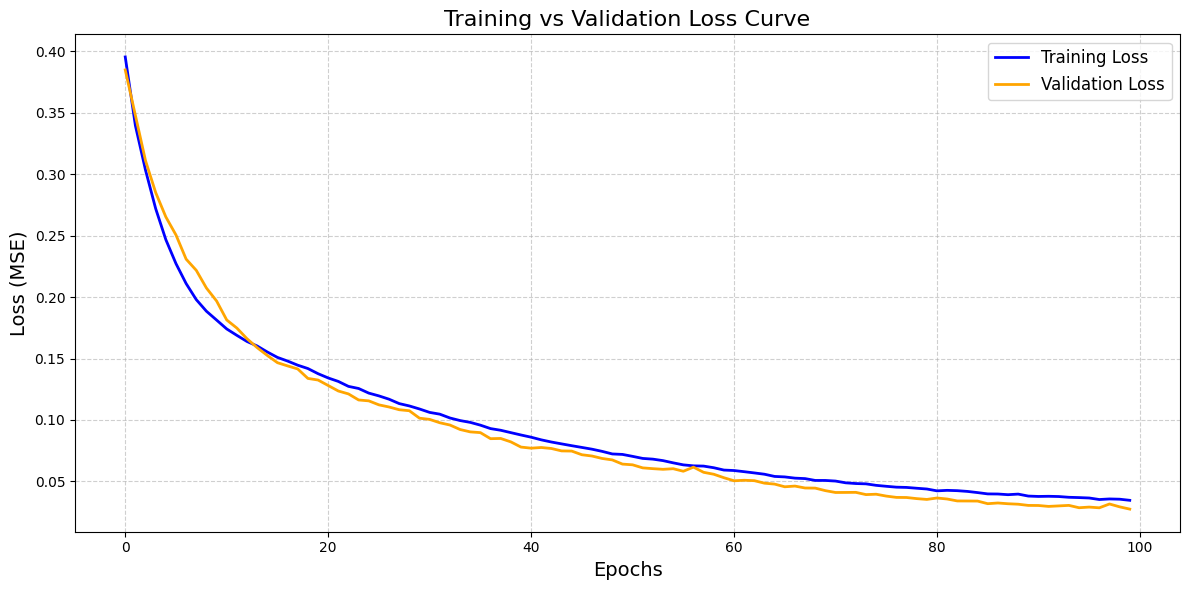

In [25]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Training vs Validation Loss Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


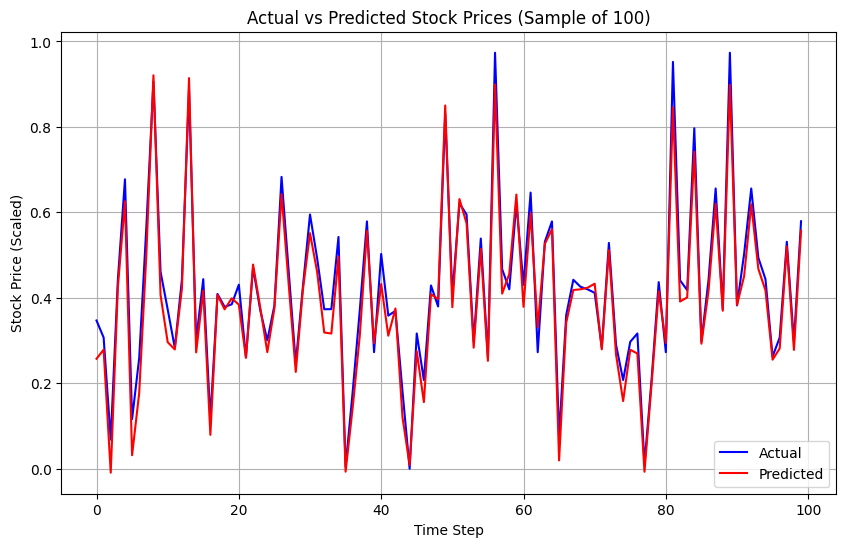

In [26]:
# Step 8.4 - Visualize actual vs predicted stock prices
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test[:100], label='Actual', color='blue')
plt.plot(y_pred[:100], label='Predicted', color='red')
plt.title('Actual vs Predicted Stock Prices (Sample of 100)')
plt.xlabel('Time Step')
plt.ylabel('Stock Price (Scaled)')
plt.legend()
plt.grid(True)
plt.show()
